<a href="https://colab.research.google.com/github/pabloinsente/CovNet_Human_Drawings/blob/master/code/CovNet_VGG_19_Age_Prediction_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age prediction from features extracted from drawings with VGG-19 CovNet

In [0]:
# install seaborn for pairplot
!pip install -q seaborn
# install rarfile to read feature file
!pip install rarfile

    100% |████████████████████████████████| 112kB 6.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/dc/84/da/8aff50941f548db5384b076d5a6a6afea0cd12672e0326edc4
Successfully built rarfile


In [0]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import rarfile
import csv


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [0]:
# Clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings
# Run this just once per sesion

Cloning into 'CovNet_Human_Drawings'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 532 (delta 0), reused 1 (delta 0), pack-reused 527
Receiving objects: 100% (532/532), 47.28 MiB | 21.90 MiB/s, done.
Resolving deltas: 100% (110/110), done.


# Data Wrangling

## Reading dataframe from CovNet for Neural Net

In [0]:
# Read csv files from compressed rar file and convert into a dataframe
rar_path = rarfile.RarFile("CovNet_Human_Drawings/data/vectors_features/vgg19_vectors_drawings_block5_pool_all.rar")
csv_file_name = "vgg19_vectors_drawings_block5_pool_all.csv"
rar_file = rarfile.RarFile.open(rar_path, csv_file_name)
raw_dataset = pd.read_csv(rar_file, sep=",", header=None)
print(raw_dataset.shape)
print(type(raw_dataset))

(258, 25088)
<class 'pandas.core.frame.DataFrame'>


In [0]:
# create headers for vectors
n_vectors = raw_dataset.shape[1]
col_list =[]
[col_list.append("vector_{}".format(vector)) for vector in range(n_vectors)]
print(col_list[0:5])
print(len(col_list))

['vector_0', 'vector_1', 'vector_2', 'vector_3', 'vector_4']
25088


In [0]:
# add headers to vectors in raw dataframe
raw_dataset.columns = col_list
print(raw_dataset.head())

   vector_0  vector_1  vector_2  vector_3  vector_4  vector_5  vector_6  \
0       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
1       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
2       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
3       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
4       0.0       0.0       0.0       0.0       0.0       0.0       0.0   

   vector_7  vector_8  vector_9      ...       vector_25078  vector_25079  \
0       0.0       0.0       0.0      ...                0.0           0.0   
1       0.0       0.0       0.0      ...                0.0           0.0   
2       0.0       0.0       0.0      ...                0.0           0.0   
3       0.0       0.0       0.0      ...                0.0           0.0   
4       0.0       0.0       0.0      ...                0.0           0.0   

   vector_25080  vector_25081  vector_25082  vector_25083  vector_25084  \
0          

In [0]:
# Get the drwawings filenames from directory 
from os import listdir
from os.path import isfile, join

path = 'CovNet_Human_Drawings/data/human_drawings_all/'
filenames = [f for f in listdir(path) if isfile(join(path, f))]
len(filenames) # This should yield 258 

258

In [0]:
# Split the strings by the underscore and return the first element (row id for merging)
filenames_crop = []
n_id = len(filenames)
[filenames_crop.append(filenames[id].split('_')[0]) for id in range(n_id)]
print(filenames_crop[0:5])
print(len(filenames_crop)) # this should yield 258

['DAM004', 'DAMa016', 'DAM081', 'DAM060', 'DAM066']
258


In [0]:
# There is "a" in the filenames. To merge this dataframe with the metadata, 
# we need to change that to uppercasem e.g. DAMa025 needs to change to DAMA025
filenames_up = [x.upper() for x in filenames_crop]
print(filenames_up[0:5])
print(len(filenames_up)) # this should yield 258

['DAM004', 'DAMA016', 'DAM081', 'DAM060', 'DAM066']
258


In [0]:
# Get rows ids as dataframe
id_list = pd.DataFrame(filenames_up, columns=['id'])
print(len(id_list)) # This should yield 258 
print(type(id_list))
print(id_list.head())

258
<class 'pandas.core.frame.DataFrame'>
        id
0   DAM004
1  DAMA016
2   DAM081
3   DAM060
4   DAM066


In [0]:
# merge vector's id and raw vectors
df_vectors = pd.concat([id_list, raw_dataset], axis=1)
print(df_vectors.shape) # this should yield (258, 25089)
print(df_vectors.head())

(258, 25089)
        id  vector_0  vector_1  vector_2  vector_3  vector_4  vector_5  \
0   DAM004       0.0       0.0       0.0       0.0       0.0       0.0   
1  DAMA016       0.0       0.0       0.0       0.0       0.0       0.0   
2   DAM081       0.0       0.0       0.0       0.0       0.0       0.0   
3   DAM060       0.0       0.0       0.0       0.0       0.0       0.0   
4   DAM066       0.0       0.0       0.0       0.0       0.0       0.0   

   vector_6  vector_7  vector_8      ...       vector_25078  vector_25079  \
0       0.0       0.0       0.0      ...                0.0           0.0   
1       0.0       0.0       0.0      ...                0.0           0.0   
2       0.0       0.0       0.0      ...                0.0           0.0   
3       0.0       0.0       0.0      ...                0.0           0.0   
4       0.0       0.0       0.0      ...                0.0           0.0   

   vector_25080  vector_25081  vector_25082  vector_25083  vector_25084  \
0   

In [0]:
# read metadata as pandas dataframe
meta_patah= "CovNet_Human_Drawings/data/metadata_participants/Study 1 DAM masterdata053117.csv"
df_metadata = pd.read_csv(meta_patah, sep=",")
print(df_metadata.shape)
print(df_metadata.head())

(107, 397)
       id  drop IS_medium_order IS_shape_order IS_site  age_yr  age4g  female  \
0  DAM001     0             SPF            ABC     PSL    5.70      3     0.0   
1  DAM002     0             FSP            ACB     PSL    5.42      3     1.0   
2  DAM003     0             FSP            BAC     PSL    4.53      2     1.0   
3  DAM004     0             SPF            BCA     PSL    5.37      3     0.0   
4  DAM005     0             PFS            CBA     PSL    4.19      2     0.0   

   adult  child        ...         PS_enjoy_electronic  PS_min_traditional  \
0      0    1.0        ...                         NaN                 NaN   
1      0    1.0        ...                         7.0                  20   
2      0    1.0        ...                         NaN                  30   
3      0    1.0        ...                         NaN                 NaN   
4      0    1.0        ...                        10.0                  15   

   PS_min_electornic             

In [0]:
# subset metadata; get id and age columns
df_metadata_age = df_metadata[['id','age_yr', 'adult']]
print(df_metadata_age.shape)
print(df_metadata_age.head())

(107, 3)
       id  age_yr  adult
0  DAM001    5.70      0
1  DAM002    5.42      0
2  DAM003    4.53      0
3  DAM004    5.37      0
4  DAM005    4.19      0


In [0]:
# check nan values 
df_metadata_age.isna().sum()
# there are missing values for age_yr that we will fix later

id        0
age_yr    5
adult     0
dtype: int64

In [0]:
# merge metadata and vectors by id
df_predict_age = pd.merge(df_metadata_age, df_vectors, on='id')
print(df_predict_age.shape) # this should yield (258, 25090)
print(df_predict_age.head())

(258, 25091)
       id  age_yr  adult  vector_0  vector_1  vector_2  vector_3  vector_4  \
0  DAM001    5.70      0       0.0       0.0       0.0       0.0       0.0   
1  DAM001    5.70      0       0.0       0.0       0.0       0.0       0.0   
2  DAM001    5.70      0       0.0       0.0       0.0       0.0       0.0   
3  DAM002    5.42      0       0.0       0.0       0.0       0.0       0.0   
4  DAM002    5.42      0       0.0       0.0       0.0       0.0       0.0   

   vector_5  vector_6      ...       vector_25078  vector_25079  vector_25080  \
0       0.0       0.0      ...                0.0           0.0      0.000000   
1       0.0       0.0      ...                0.0           0.0     60.662159   
2       0.0       0.0      ...                0.0           0.0      0.000000   
3       0.0       0.0      ...                0.0           0.0      0.000000   
4       0.0       0.0      ...                0.0           0.0      0.000000   

   vector_25081  vector_25082  

In [0]:
# Let's export the pandas dataframe to a csv for later
df_predict_age.to_csv("predict_age_from_vectors_block5_pool_all.csv", sep=',', index= False)

## Cleaning the data 

In [0]:
# print NA values
NA = df_predict_age.isna().sum()
print(NA[0:2]) # we have 11 rows with missing values for age

id         0
age_yr    11
dtype: int64


In [0]:
from fancyimpute import IterativeImputer
# IterativeImputer: A strategy for imputing missing values by modeling each 
# feature with missing values as a function of other features in a round-robin fashion.

# IterativeImputer only works with scalar values so we have to get rid of 
# id label first 
df_predict_age_na = df_predict_age_na = df_predict_age.loc[:, df_predict_age.columns != 'id']

# now we can do the imputation 
df_predict_age_imp = IterativeImputer().fit_transform(df_predict_age_na)

Using TensorFlow backend.


In [0]:
# IterativeImputer returns a np array, so we need to change it back to pandas
df_predict_age_pn = pd.DataFrame(df_predict_age_imp)
print(type(df_predict_age_pn))
print(df_predict_age_pn.head())

<class 'pandas.core.frame.DataFrame'>
   0      1      2      3      4      5      6      7      8      9      \
0   5.70    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1   5.70    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2   5.70    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3   5.42    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4   5.42    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

   ...    25080  25081      25082  25083     25084  25085  25086  25087  \
0  ...      0.0    0.0   0.000000    0.0  0.000000    0.0    0.0    0.0   
1  ...      0.0    0.0  60.662159    0.0  0.000000    0.0    0.0    0.0   
2  ...      0.0    0.0   0.000000    0.0  0.327322    0.0    0.0    0.0   
3  ...      0.0    0.0   0.000000    0.0  0.028213    0.0    0.0    0.0   
4  ...      0.0    0.0   0.000000    0.0  1.859237    0.0    0.0    0.0   

   25088  25089  
0    0.0    0.0  
1    0.0    0.0  
2    0

In [0]:
# merge vector's id and raw vectors
df_predict_age_fix = pd.concat([id_list, df_predict_age_pn], axis=1)
print(df_predict_age_fix.shape) # this should yield (258, 25089)
print(df_predict_age_fix.head())

(258, 25091)
        id     0    1    2    3    4    5    6    7    8  ...    25080  25081  \
0   DAM004  5.70  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
1  DAMA016  5.70  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
2   DAM081  5.70  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
3   DAM060  5.42  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   
4   DAM066  5.42  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...      0.0    0.0   

       25082  25083     25084  25085  25086  25087  25088  25089  
0   0.000000    0.0  0.000000    0.0    0.0    0.0    0.0    0.0  
1  60.662159    0.0  0.000000    0.0    0.0    0.0    0.0    0.0  
2   0.000000    0.0  0.327322    0.0    0.0    0.0    0.0    0.0  
3   0.000000    0.0  0.028213    0.0    0.0    0.0    0.0    0.0  
4   0.000000    0.0  1.859237    0.0    0.0    0.0    0.0    0.0  

[5 rows x 25091 columns]


In [0]:
# let's get the original col names to add that back to the new dataframe
col_names = list(df_predict_age.columns.values)
print(col_names[0:5])

['id', 'age_yr', 'adult', 'vector_0', 'vector_1']


In [0]:
# add headers to vectors into dataframe after imputation
df_predict_age_fix.columns = col_names
print(df_predict_age_fix.head())

        id  age_yr  adult  vector_0  vector_1  vector_2  vector_3  vector_4  \
0   DAM004    5.70    0.0       0.0       0.0       0.0       0.0       0.0   
1  DAMA016    5.70    0.0       0.0       0.0       0.0       0.0       0.0   
2   DAM081    5.70    0.0       0.0       0.0       0.0       0.0       0.0   
3   DAM060    5.42    0.0       0.0       0.0       0.0       0.0       0.0   
4   DAM066    5.42    0.0       0.0       0.0       0.0       0.0       0.0   

   vector_5  vector_6      ...       vector_25078  vector_25079  vector_25080  \
0       0.0       0.0      ...                0.0           0.0      0.000000   
1       0.0       0.0      ...                0.0           0.0     60.662159   
2       0.0       0.0      ...                0.0           0.0      0.000000   
3       0.0       0.0      ...                0.0           0.0      0.000000   
4       0.0       0.0      ...                0.0           0.0      0.000000   

   vector_25081  vector_25082  vector_

In [0]:
# print NA values before imputation
NA = df_predict_age.isna().sum()
print(NA[0:2]) # we have 11 rows with missing values for age

# print NA values after imputation
NA_imp = df_predict_age_fix.isna().sum()
print(NA_imp[0:2]) # Now we have 0 NA values in our new dataframe

id         0
age_yr    11
dtype: int64
id        0
age_yr    0
dtype: int64


In [0]:
# Let's export the pandas dataframe to a csv for later
df_predict_age_fix.to_csv("predict_age_from_vectors_block5_pool_all_imp.csv", sep=',', index=False)

# Preprocessing data for Neural Network

## Split the data into train and test for training

To avoid re-running the data wrangling process, now we can load the dataset from memory. We can skip everything above this section by running the two cells below

In [0]:
# install seaborn for pairplot
!pip install -q seaborn

from __future__ import absolute_import, division, print_function

import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.test.gpu_device_name())

1.13.1
/device:GPU:0


In [0]:
# Run this only if you haven't clone the data before
# Clone the data into Colab
! git clone https://github.com/pabloinsente/CovNet_Human_Drawings

Cloning into 'CovNet_Human_Drawings'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 542 (delta 4), reused 7 (delta 2), pack-reused 527
Receiving objects: 100% (542/542), 51.39 MiB | 31.10 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [0]:
# Read dataset from memory
df_path = "CovNet_Human_Drawings/data/merged_dataframes_prediction/predict_age_from_vectors_block5_pool_all_imp.csv"
df_net = pd.read_csv(df_path, sep=",")
print(df_net.shape)
print(df_net.head())

(258, 25091)
        id  age_yr  adult  vector_0  vector_1  vector_2  vector_3  vector_4  \
0   DAM004    5.70    0.0       0.0       0.0       0.0       0.0       0.0   
1  DAMA016    5.70    0.0       0.0       0.0       0.0       0.0       0.0   
2   DAM081    5.70    0.0       0.0       0.0       0.0       0.0       0.0   
3   DAM060    5.42    0.0       0.0       0.0       0.0       0.0       0.0   
4   DAM066    5.42    0.0       0.0       0.0       0.0       0.0       0.0   

   vector_5  vector_6      ...       vector_25078  vector_25079  vector_25080  \
0       0.0       0.0      ...                0.0           0.0      0.000000   
1       0.0       0.0      ...                0.0           0.0     60.662159   
2       0.0       0.0      ...                0.0           0.0      0.000000   
3       0.0       0.0      ...                0.0           0.0      0.000000   
4       0.0       0.0      ...                0.0           0.0      0.000000   

   vector_25081  vector_2

In [0]:
# We will use 70% of the data for training and 30% for testing
train_dataset = df_net.sample(frac=0.7,random_state=0)
test_dataset = df_net.drop(train_dataset.index)

In [0]:
# Now we can drop the "id" from the dataset
train_dataset = train_dataset.drop(['id'], axis=1)
test_dataset = test_dataset.drop(['id'], axis=1)

In [0]:
# We will skip exploring the data because we have ~25,000 uninterpretable features

## Split features from labels


In [0]:
# Separate the target value for linear model predicting "age" 
# This label is the value that we will train the model to predict.
train_labels_l = train_dataset.pop('age_yr')
test_labels_l = test_dataset.pop('age_yr')

In [0]:
# Separate the target value for logistic model predicting "adult/child" 
# This label is the value that we will train the model to predict.
train_labels_b = train_dataset.pop('adult')
test_labels_b = test_dataset.pop('adult')

## Normalizing data
It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.


We will normalizing the data using sklearn StandartScaler. It is fitted to train data, because I assume that I know nothing about test data. Both datasets are transformed.

In [0]:
scaler = StandardScaler()
scaler.fit(train_dataset)
normed_train_data = scaler.transform(train_dataset)
normed_test_data = scaler.transform(test_dataset)

In [0]:
# Check if there are missing values
print(np.isnan(np.sum(normed_train_data)))
# check if there are inf values
print(np.isinf(np.sum(normed_train_data)))

False
False


## Dimensionality reduction before training
We will use PCA to reduce dimensionality before training the model

Text(0, 0.5, 'Cumulative explained variance')

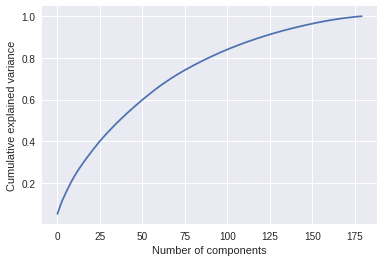

In [0]:
# Let's print out the accumulated explained variance as we get
# more components using PCA 

pca = PCA(n_components=180)
pca.fit(normed_train_data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [0]:
# Looks like with 200 components we retain all the variance
NCOMPONENTS = 180

pca = PCA(n_components=NCOMPONENTS)
X_pca_train = pca.fit_transform(normed_train_data)
X_pca_test = pca.transform(normed_test_data)
pca_std = np.std(X_pca_train)

In [0]:
# Now we can check that we have a dataset with the same number
# of rows, but with only (206, 200) instead of (206, 25088) for
# the training set

# Training data
print(normed_train_data.shape)
print(X_pca_train.shape)

# Test data
print(normed_test_data.shape)
print(X_pca_test.shape)

(181, 25088)
(181, 180)
(77, 25088)
(77, 180)


# Building the Neural Network - Linear Model
Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value, age

In [0]:
# Let's layout the model architecture
model_l = tf.keras.models.Sequential([
    tf.keras.layers.Dense(NCOMPONENTS, activation='relu', input_dim=NCOMPONENTS),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [0]:
# Summary of net architecture 
model_l.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 180)               32580     
_________________________________________________________________
dense_25 (Dense)             (None, 64)                11584     
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 48,389
Trainable params: 48,389
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Let's compile the model using:
# - 'mean_squared_error' as the loss 
# - 'RMSprop' as the optimizer
# - '0.001' as the learning rate

from tensorflow.keras.optimizers import RMSprop

model_l.compile(loss='mean_squared_error',
              optimizer=RMSprop(lr=0.001),
              metrics=['mean_absolute_error', 'mean_squared_error'])

## Train linear  model
Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
# Now we can train the model
n_epochs = 1000

history = model_l.fit(X_pca_train, train_labels_l,
                    epochs=n_epochs, 
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [0]:
# Visualize the model's training progress using the stats stored in the history object.

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.head())
print(hist.tail())

        loss  mean_absolute_error  mean_squared_error   val_loss  \
0  74.670414             6.059527           74.670410  91.144399   
1  23.245732             3.271144           23.245733  73.656368   
2   9.258283             1.820988            9.258283  70.298713   
3   3.991708             1.137012            3.991708  80.123589   
4   2.092985             0.895681            2.092985  68.463808   

   val_mean_absolute_error  val_mean_squared_error  epoch  
0                 7.080488               91.144402      0  
1                 6.218984               73.656372      1  
2                 6.111970               70.298706      2  
3                 6.578382               80.123589      3  
4                 6.025568               68.463806      4  
         loss  mean_absolute_error  mean_squared_error   val_loss  \
995  0.067561             0.142512            0.067561  62.171372   
996  0.049705             0.138778            0.049705  62.322144   
997  0.060889           

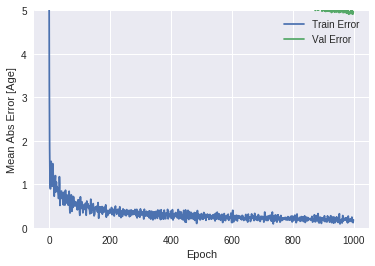

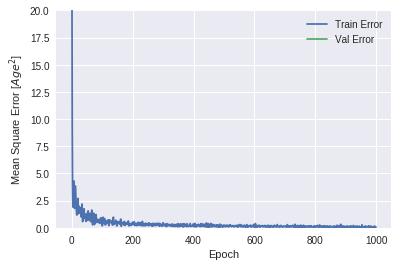

In [0]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Age]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Age^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [0]:
loss, mae, mse = model_l.evaluate(X_pca_test, test_labels_l, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Age".format(mae))

Testing set Mean Abs Error: 13.41 Age


## Test linear model

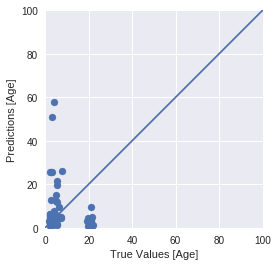

In [0]:
test_predictions = model_l.predict(X_pca_test).flatten()

plt.scatter(test_labels_l, test_predictions)
plt.xlabel('True Values [Age]')
plt.ylabel('Predictions [Age]')
plt.axis('equal')
plt.axis('square')
#plt.xlim([0,plt.xlim()[1]])
#plt.ylim([0,plt.ylim()[1]])
plt.xlim([0,100])
plt.ylim([0,100])
_ = plt.plot([-100, 100], [-100, 100])

The data is essencially binomial, therefore, a linear model will not work. We have to treat this as a binary calssification problem

#Building the Neural Network - Logistic Model
Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a 0 or 1, for child or adult

In [0]:
# Let's layout the model architecture
model_log = tf.keras.models.Sequential([
    tf.keras.layers.Dense(NCOMPONENTS, activation='relu', input_dim=NCOMPONENTS),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation= 'sigmoid')
])

In [0]:
# Summary of net architecture 
model_log.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 180)               32580     
_________________________________________________________________
dense_29 (Dense)             (None, 64)                11584     
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 48,389
Trainable params: 48,389
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Let's compile the model using:
# - 'binary_crossentropy' as the loss 
# - 'adam' as the optimizer

model_log.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

## Train logistic model
Train the model for 10 epochs, and record the training and validation accuracy in the history object.

In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
# Now we can train the model
n_epochs = 50

history = model_log.fit(X_pca_train, train_labels_b,
                    epochs=n_epochs, 
                    validation_split = 0.2, 
                    verbose=0,
                    shuffle=True,
                    callbacks=[PrintDot()])


..................................................

In [0]:
# Visualize the model's training progress using the stats stored in the history object.

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist.head())
print(hist.tail())

        acc      loss   val_acc  val_loss  epoch
0  0.500000  1.905977  0.675676  2.089891      0
1  0.847222  0.842941  0.675676  2.609539      1
2  0.868056  0.378285  0.675676  2.119879      2
3  0.972222  0.098029  0.702703  1.617473      3
4  1.000000  0.036867  0.675676  1.322936      4
    acc      loss   val_acc  val_loss  epoch
45  1.0  0.000733  0.675676  2.021567     45
46  1.0  0.000713  0.675676  2.022474     46
47  1.0  0.000691  0.675676  2.034317     47
48  1.0  0.000670  0.675676  2.031604     48
49  1.0  0.000652  0.675676  2.046812     49


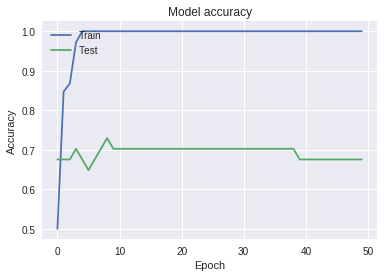

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Test logistic model

In [0]:
test_log_model = model_log.evaluate(X_pca_test, test_labels_b)

# We get an accuracy of ~73% in the testing set

77/77 [==============================] - 0s 149us/sample - loss: 1.7572 - acc: 0.7273


In [0]:
# Predicting the Test set results
y_pred = model_log.predict(X_pca_test)
y_pred = (y_pred > 0.5)

In [0]:
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
true_neg, false_pos, false_neg, true_pos = confusion_matrix(test_labels_b, y_pred).ravel()
print("True Negatives:", true_neg, "False negatives:", false_neg, 
      "True Positives:", true_pos, "False Positives:", false_pos)

True Negatives: 55 False negatives: 15 True Positives: 1 False Positives: 6


# Resources

Here links to resources that I used to build the networks:

- For basic linear prediction 
https://www.tensorflow.org/tutorials/keras/basic_regression

- For basic binary classification 
https://medium.com/@pushkarmandot/build-your-first-deep-learning-neural-network-model-using-keras-in-python-a90b5864116d

- For imputation of missing values 
https://github.com/iskandr/fancyimpute

- For PCA decomposition 
https://www.kaggle.com/pmmilewski/pca-decomposition-and-keras-neural-network

- For visualization 
https://keras.io/visualization/


